#Hybrid NN image classification

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
!pip install torch
from torch import Tensor
from torch.nn import Linear, CrossEntropyLoss, MSELoss
from torch.optim import LBFGS
!pip install qiskit
!pip install qiskit_machine_learning
from qiskit  import Aer, QuantumCircuit
from qiskit.utils import QuantumInstance
from qiskit.opflow import AerPauliExpectation
from qiskit.circuit import Parameter
from qiskit.circuit.library import RealAmplitudes, ZZFeatureMap
from qiskit_machine_learning.neural_networks import CircuitQNN, TwoLayerQNN
from qiskit_machine_learning.connectors import TorchConnector

In [ ]:

from torch import cat, no_grad, manual_seed
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
import torch.optim as optim
from torch.nn import (Module, Conv2d, Linear, Dropout2d, NLLLoss,
                     MaxPool2d, Flatten, Sequential, ReLU)
import torch.nn.functional as F
import torch
import torchvision.transforms as transforms

Creat qbit simulation:

In [4]:
qi = QuantumInstance(Aer.get_backend('aer_simulator_statevector'))

Read train set from CIFAR10

In [7]:
# Train Dataset

manual_seed(1)
classes = ('plane', 'car', 'bird')
batch_size = 10  #set batch size as 10
n_samples = 8000 # We will concentrate on the first 8000*3 samples
transformss=transforms.Compose([transforms.ToTensor(),transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])  #Normolize the data to [-1,1]

# Use pre-defined torchvision function to load CIFAR10 train data
X_train = datasets.CIFAR10(root='hakcathon-qisikit/', train=True, download=True,
                         transform=transformss)


Files already downloaded and verified


Select only 4 categories in CIFAR10

In [9]:
#Select only 3 categories
train_targets = np.array(X_train.targets)
idx = np.append(np.where(train_targets==0)[0][:n_samples],np.where(train_targets==1)[0][:n_samples])
idx = np.append(idx,np.where(train_targets == 2)[0][:n_samples])

X_train.data = X_train.data[idx]
X_train.targets = train_targets[idx]

train_loader = DataLoader(X_train, batch_size=batch_size, shuffle=True)

Have a peek in Train set

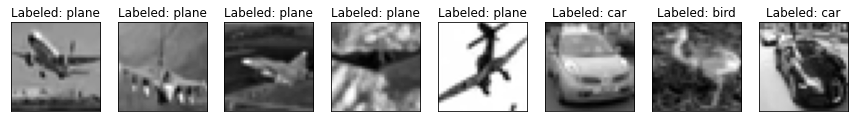

In [10]:
n_samples_show = 8

data_iter = iter(train_loader)
fig, axes = plt.subplots(nrows=1, ncols=n_samples_show, figsize=(15, 3))

while n_samples_show > 0:
    images, targets = data_iter.__next__()

    axes[n_samples_show - 1].imshow(images[0, 0].numpy().squeeze(), cmap='gray')
    axes[n_samples_show - 1].set_xticks([])
    axes[n_samples_show - 1].set_yticks([])
    axes[n_samples_show - 1].set_title("Labeled: {}".format(classes[targets[0]]))

    n_samples_show -= 1

Read test set in CIFAR10

In [11]:
#Test Dataset
manual_seed(5)
 
n_samples = 500 #500*3 samples for test set
transformss=transforms.Compose([transforms.ToTensor(),transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))]) #Normolize the data to [-1,1]

X_test = datasets.CIFAR10(root='hakcathon-qisikit/', train=False, download=True,
                        transform=transformss)

Files already downloaded and verified


In [12]:
#Select only 3 categories
test_targets = np.array(X_test.targets)
idx = np.append(np.where(test_targets==0)[0][:n_samples],np.where(test_targets==1)[0][:n_samples])
idx = np.append(idx,np.where(test_targets == 2)[0][:n_samples])

X_test.data = X_test.data[idx]
X_test.targets = test_targets[idx]

test_loader = DataLoader(X_test, batch_size=batch_size, shuffle=True)

In [13]:
#check shape
X_test.data.shape

(1500, 32, 32, 3)

In [14]:
#check shape
X_train.data.shape

(15000, 32, 32, 3)

Define QNN

From the viewpoint of operational efficiency, we do not use num_feature more than 2 

In [21]:
# Define QNN
num_features = 2
feature_map = ZZFeatureMap(num_features)
ansatz = RealAmplitudes(num_features, reps=1)
qnn4 = TwoLayerQNN(num_features, feature_map, ansatz, input_gradients=True, exp_val=AerPauliExpectation(), quantum_instance=qi)
print(qnn4.operator)

ComposedOp([
  OperatorMeasurement(1.0 * ZZ),
  CircuitStateFn(
       ┌──────────────────────────┐┌──────────────────────────────────────┐
  q_0: ┤0                         ├┤0                                     ├
       │  ZZFeatureMap(x[0],x[1]) ││  RealAmplitudes(θ[0],θ[1],θ[2],θ[3]) │
  q_1: ┤1                         ├┤1                                     ├
       └──────────────────────────┘└──────────────────────────────────────┘
  )
])


Define torch NN

In [22]:
# Define torch NN module

class Net(Module):

    def __init__(self):
        super().__init__()
        self.conv1 = Conv2d(3, 10, kernel_size=5)
        self.conv2 = Conv2d(10, 16, kernel_size=5)
        self.dropout = Dropout2d()
        self.fc1 = Linear(400, 128)
        self.fc2 = Linear(128, 2)
        self.qnn = TorchConnector(qnn4)
        self.fc3 = Linear(1, 3)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.max_pool2d(x, 2)
        x = F.relu(self.conv2(x))
        x = F.max_pool2d(x, 2)
        x = self.dropout(x)

        x = x.view(x.shape[0], -1)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        x = self.qnn(x)  # apply QNN
        x = self.fc3(x)
        return x

model4 = Net()

In [23]:
# Define model, optimizer, and loss function
optimizer = optim.Adam(model4.parameters(), lr=0.001)
criterion = CrossEntropyLoss() # we use cross entropy loss
loss_func = NLLLoss()

In [ ]:
# Start training
epochs = 20 
loss_list = [] 
model4.train() 

for epoch in range(epochs):
    total_loss = []
    for batch_idx, (data, target) in enumerate(train_loader):
        optimizer.zero_grad(set_to_none=True)  
        output = model4(data)                  
        loss = criterion(output, target)       
        loss.backward()                       
        optimizer.step()                       
        total_loss.append(loss.item()) 
    loss_list.append(sum(total_loss)/len(total_loss))
    print('Training [{:.0f}%]\tLoss: {:.4f}'.format(
        100. * (epoch + 1) / epochs, loss_list[-1]))
    
torch.save(model4.state_dict(),"hakcathon-qisikit/model_final.pth")

In [ ]:
# Plot loss convergence
plt.plot(loss_list)
plt.title('Hybrid NN Training Convergence')
plt.xlabel('Training Iterations')
plt.ylabel('Cross Entropy Loss')
plt.show()

In [24]:
model = Net()
model.load_state_dict(torch.load("hakcathon-qisikit/model_final.pth"))
model.eval()  # set model to evaluation mode
total_loss = []
with no_grad():

    correct = 0
    for batch_idx, (data, target) in enumerate(test_loader):
        output = model(data)
        if len(output.shape) == 1:
            output = output.reshape(1, *output.shape)

        pred = output.argmax(dim=1, keepdim=True)
        correct += pred.eq(target.view_as(pred)).sum().item()

        loss = criterion(output, target)
        total_loss.append(loss.item())

    print('Performance on test data:\n\tLoss: {:.4f}\n\tAccuracy: {:.1f}%'
          .format(sum(total_loss) / len(total_loss),
                  correct / len(test_loader) / batch_size * 100)
    )

Performance on test data:
	Loss: 0.4757
	Accuracy: 83.2%


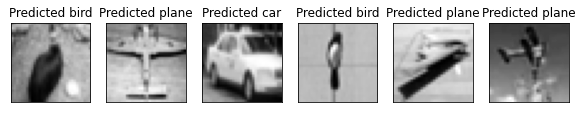

In [25]:
# Plot predicted labels

n_samples_show = 6
count = 0
fig, axes = plt.subplots(nrows=1, ncols=n_samples_show, figsize=(10, 3))

model.eval()
with no_grad():
    for batch_idx, (data, target) in enumerate(test_loader):
        if count == n_samples_show:
            break
        output = model(data[0:1])
        if len(output.shape) == 1:
            output = output.reshape(1, *output.shape)

        pred = output.argmax(dim=1, keepdim=True)

        axes[count].imshow(data[0,0].numpy().squeeze(), cmap='gray')

        axes[count].set_xticks([])
        axes[count].set_yticks([])
        axes[count].set_title('Predicted {}'.format(classes[pred.item()]))

        count += 1

#Compare with CNN without QNN

In [15]:
# Define torch NN module

class Net_CNN(Module):

    def __init__(self):
        super().__init__()
        self.conv1 = Conv2d(3, 10, kernel_size=5)
        self.conv2 = Conv2d(10, 16, kernel_size=5)
        self.dropout = Dropout2d()
        self.fc1 = Linear(400, 128)
        self.fc2 = Linear(128, 3)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.max_pool2d(x, 2)
        x = F.relu(self.conv2(x))
        x = F.max_pool2d(x, 2)
        x = self.dropout(x)

        x = x.view(x.shape[0], -1)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x
model_cnn = Net_CNN()

In [17]:
optimizer = optim.Adam(model_cnn.parameters(), lr=0.001)
criterion = CrossEntropyLoss() # we use cross entropy loss

In [18]:
epochs = 20 
loss_list = [] 
model_cnn.train() 

for epoch in range(epochs):
    total_loss = []
    for batch_idx, (data, target) in enumerate(train_loader):
        optimizer.zero_grad(set_to_none=True)  
        output = model_cnn(data)                  
        loss = criterion(output, target)       
        loss.backward()                       
        optimizer.step()                       
        total_loss.append(loss.item()) 
    loss_list.append(sum(total_loss)/len(total_loss))
    print('Training [{:.0f}%]\tLoss: {:.4f}'.format(
        100. * (epoch + 1) / epochs, loss_list[-1]))
    
torch.save(model_cnn.state_dict(),"hakcathon-qisikit/model_cnn.pth")

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


Training [5%]	Loss: 0.7276
Training [10%]	Loss: 0.5653
Training [15%]	Loss: 0.5292
Training [20%]	Loss: 0.4855
Training [25%]	Loss: 0.4691
Training [30%]	Loss: 0.4471
Training [35%]	Loss: 0.4357
Training [40%]	Loss: 0.4183
Training [45%]	Loss: 0.4045
Training [50%]	Loss: 0.3933
Training [55%]	Loss: 0.3820
Training [60%]	Loss: 0.3842
Training [65%]	Loss: 0.3819
Training [70%]	Loss: 0.3626
Training [75%]	Loss: 0.3676
Training [80%]	Loss: 0.3528
Training [85%]	Loss: 0.3525
Training [90%]	Loss: 0.3465
Training [95%]	Loss: 0.3420
Training [100%]	Loss: 0.3326


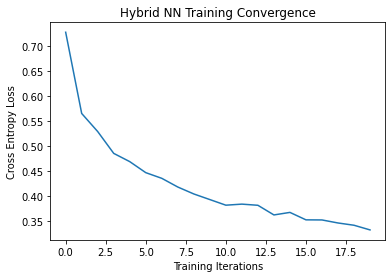

In [19]:
# Plot loss convergence
plt.plot(loss_list)
plt.title('Hybrid NN Training Convergence')
plt.xlabel('Training Iterations')
plt.ylabel('Cross Entropy Loss')
plt.show()

In [20]:
model = Net_CNN()
model.load_state_dict(torch.load("hakcathon-qisikit/model_cnn.pth"))
model.eval()  # set model to evaluation mode
total_loss = []
with no_grad():

    correct = 0
    for batch_idx, (data, target) in enumerate(test_loader):
        output = model(data)
        if len(output.shape) == 1:
            output = output.reshape(1, *output.shape)

        pred = output.argmax(dim=1, keepdim=True)
        correct += pred.eq(target.view_as(pred)).sum().item()

        loss = criterion(output, target)
        total_loss.append(loss.item())

    print('Performance on test data:\n\tLoss: {:.4f}\n\tAccuracy: {:.1f}%'
          .format(sum(total_loss) / len(total_loss),
                  correct / len(test_loader) / batch_size * 100)
    )

Performance on test data:
	Loss: 0.3455
	Accuracy: 87.9%
